Reading the Datasets

In [1]:
negative_examples = open('./data/neg_A0201.txt').read().split('\n')
positive_examples = open('./data/pos_A0201.txt').read().split('\n')

In [2]:
# extractive all letters which appear in the dataset
all_letters = [list(x) for x in negative_examples + positive_examples]
all_letters_flat = list(set([x for xs in all_letters for x in xs]))

# 2.a -> mapping each letter into an int from 0 to 8 
char_to_label = {k: idx for idx, k in enumerate(all_letters_flat)}

# reverse the mapping for easy use later
label_to_char = {v:k for k,v in char_to_label.items()}

In [3]:
def convert_text_to_record(acid_txt, label):
    prefix = [0] if label == 0 else [2]
    return {
        'input': [char_to_label[c] for c in list(acid_txt)],
        'label': label
    }
# converting the datasets into 
negative_examples = [convert_text_to_record(r, 0) for r in negative_examples]
positive_examples = [convert_text_to_record(r, 1) for r in positive_examples]

In [4]:
import pandas as pd

all_examples = negative_examples + positive_examples
all_examples_df = pd.DataFrame(all_examples)
all_examples_df = all_examples_df.sample(frac=1.0)

In [5]:
from sklearn.model_selection import train_test_split

all_examples_df = all_examples_df[all_examples_df['input'].apply(lambda x: len(x) == 9)]
train_before_alter, test = train_test_split(all_examples_df, test_size=0.1)

In [6]:
len(train_before_alter[train_before_alter['label'] == 1]) / len(train_before_alter)

0.10770599175224388

In [8]:
import torch
import numpy as np
import torch.nn.functional as F

UP_SAMPLING_RATIO = 4
DOWN_SAMPLING_RATIO = 2


train_before_alter = train_before_alter.sample(frac=1.0)

train = pd.concat([np.array_split(train_before_alter[train_before_alter['label'] == 0], DOWN_SAMPLING_RATIO)[0]] + [train_before_alter[train_before_alter['label'] == 1] for _ in range(UP_SAMPLING_RATIO)] ).sample(frac=1.0)

train_before_alter_data = torch.Tensor(train_before_alter['input'].to_list())
train_before_alter_data = torch.flatten(F.one_hot(train_before_alter_data.to(torch.int64)),start_dim=1).to(torch.float)
train_before_alter_labels = torch.Tensor(train_before_alter['label'].to_list()).view(-1, 1)

train_data = torch.Tensor([np.array(x) for x in train['input'].values])
train_labels = torch.Tensor(train['label'].values).view(-1, 1)

test_data = torch.Tensor(test['input'].to_list())
test_data = torch.flatten(F.one_hot(test_data.to(torch.int64)),start_dim=1).to(torch.float)
test_labels = torch.Tensor(test['label'].to_list()).view(-1, 1)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/tmp/ipykernel_4070/2377071856.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  train_data = torch.Tensor([np.array(x) for x in train['input'].values])


In [9]:
train['label'].describe()

count    21691.000000
mean         0.491264
std          0.499935
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [10]:
import math
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim


# Define the MLP model
class MLP(nn.Module):
    def __init__(self, activation_f, input_size, hidden_size, n_hidden_layers):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.act1 = activation_f()
        
        self.hidden_layers = nn.ModuleList()
        for i in range(n_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(activation_f())
            self.hidden_layers.append(nn.Dropout(0.2))

        self.output = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.sigmoid(self.output(x))
        return x
    
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [19]:
import copy
from torch.optim.lr_scheduler import LinearLR
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_experiment(input_size_i, hidden_size_i, n_hidden_layers_i, learning_rate_i, n_epochs_i, batch_size_i, activation_f_i, train_base_ds=train_before_alter, under_sampling_ratio=2, over_sampling_ratio=4, model_class=MLP):
    train_i = pd.concat([np.array_split(train_base_ds[train_base_ds['label'] == 0], under_sampling_ratio)[0]] + [train_base_ds[train_base_ds['label'] == 1] for _ in range(over_sampling_ratio)] ).sample(frac=1.0)
    
    training_data = torch.Tensor([np.array(x) for x in train_i['input'].values])
    training_data = torch.flatten(F.one_hot(training_data.to(torch.int64)),start_dim=1).to(torch.float)
    training_labels = torch.Tensor(train_i['label'].values).view(-1, 1)
    
    model_i = model_class(activation_f_i, input_size_i, hidden_size_i, n_hidden_layers_i).to(device)

    # loss function and optimizer
    loss_fn = nn.BCEWithLogitsLoss()  # binary cross entropy
    optimizer = optim.Adam(model_i.parameters(), lr=learning_rate_i)
    scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=10)

    
    batch_start = torch.arange(0, len(training_data), batch_size_i)
    
    train_losses = []
    test_losses = []
    train_precisions = []
    train_recalls = []
    test_precisions = []
    test_recalls = []
    test_accs = []
    train_accs = []
    
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    
    for epoch in range(n_epochs_i):
        model_i.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = training_data[start:start+batch_size_i].to(device)
                y_batch = training_labels[start:start+batch_size_i].to(device)
                # forward pass
                y_pred = model_i(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        scheduler.step()
        model_i.eval()
        with torch.no_grad():
            y_pred = model_i(test_data.to(device)).cpu()
            test_acc = (y_pred.round() == test_labels).float().mean()
            test_accs.append(float(test_acc))
            y_train_pred = model_i(train_before_alter_data.to(device)).cpu()
            train_acc = (y_train_pred.round() == train_before_alter_labels).float().mean()
            train_accs.append(float(train_acc))
            if float(test_acc) > best_acc:
                best_acc = float(test_acc)
                best_weights = copy.deepcopy(model_i.state_dict())
            
            train_loss = loss_fn(y_train_pred, train_before_alter_labels)
            train_predictions = (y_train_pred >= 0.5).float()
            train_precision = precision_score(train_before_alter_labels, train_predictions, zero_division=1)
            train_recall = recall_score(train_before_alter_labels, train_predictions)
            train_losses.append(train_loss.item())
            train_precisions.append(train_precision)
            train_recalls.append(train_recall)
    
            # Test metrics
            test_outputs = model_i(test_data.to(device)).cpu()
            test_loss = loss_fn(test_outputs, test_labels)
            test_predictions = (test_outputs >= 0.5).float()
            test_precision = precision_score(test_labels, test_predictions, zero_division=1)
            test_recall = recall_score(test_labels, test_predictions)
            test_losses.append(test_loss.item())
            test_precisions.append(test_precision)
            test_recalls.append(test_recall)

    print(f"hidden_size: {hidden_size_i}, n_hidden_layers: {n_hidden_layers_i}, LR: {learning_rate_i}, batch_size: {batch_size_i}, activation: {activation_f_i}")
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(test_recalls)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(test_recalls)+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Losses')
    plt.show()
    
    
    # Plotting precision and recall
    plt.figure(figsize=(10, 5))
    # plt.plot(range(1, len(test_recalls)+1), train_precisions, label='Training Precision')
    plt.plot(range(1, len(test_recalls)+1), train_recalls, label='Training Recall')
    plt.plot(range(1, len(test_recalls)+1), train_accs, label='Training Accuracy')
    # plt.plot(range(1, len(test_recalls)+1), test_precisions, label='Test Precision')
    plt.plot(range(1, len(test_recalls)+1), test_recalls, label='Test Recall')
    plt.plot(range(1, len(test_recalls)+1), test_accs, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Precision and Recall')
    plt.show()
    
    cm = confusion_matrix(test_labels, (test_outputs >= 0.5).float())
    print(cm)
    cmd = ConfusionMatrixDisplay(cm)
    cmd.plot()
    print(f"best accuracy: {best_acc}")
    model_i.load_state_dict(best_weights)
    return model_i

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 180, n_hidden_layers: 2, LR: 0.001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


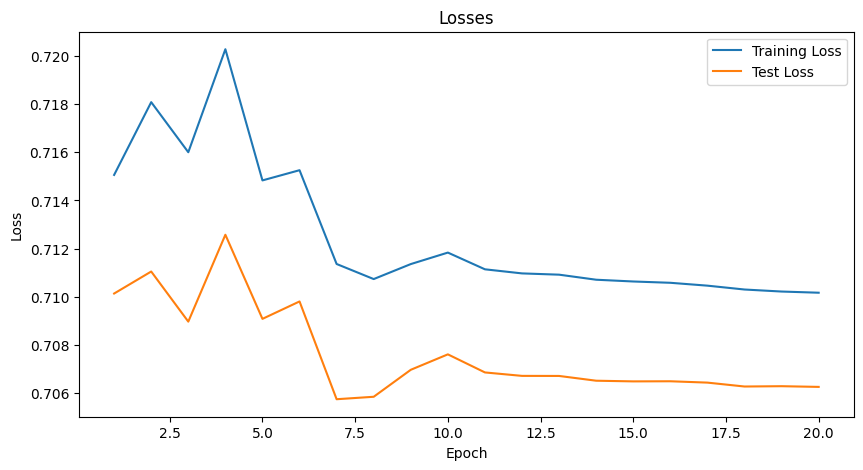

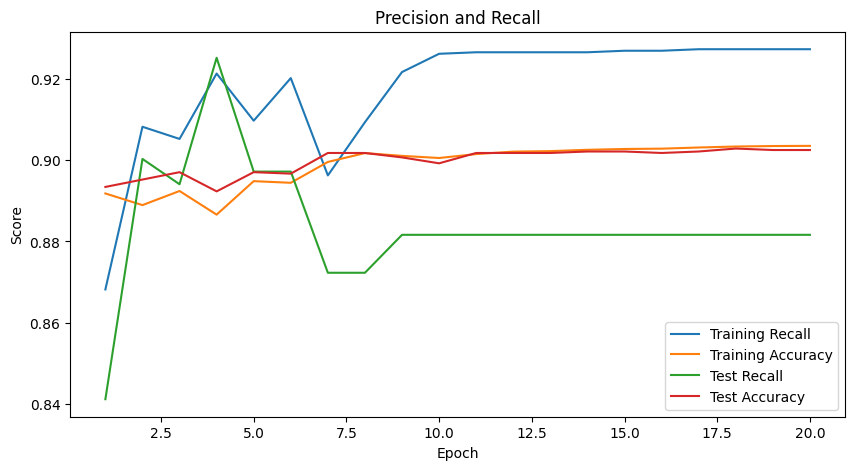

[[2198  230]
 [  38  283]]


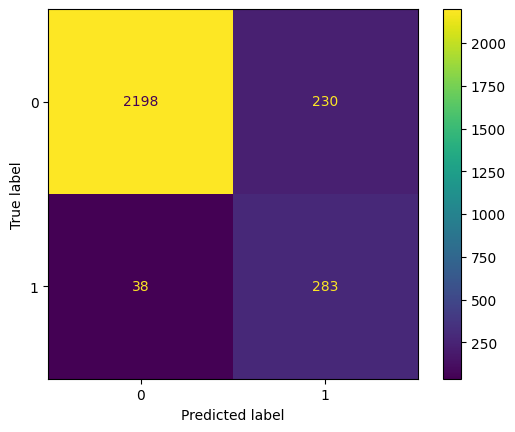

In [11]:
class MLP_WO_Activation(nn.Module):
    def __init__(self, _, input_size, hidden_size, n_hidden_layers):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        
        self.hidden_layers = nn.ModuleList()
        for i in range(n_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.Dropout(0.2))

        self.output = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        
        for layer in self.hidden_layers:
            x = layer(x)
        
        x = self.sigmoid(self.output(x))
        return x

model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = 9 * 20,
        n_hidden_layers_i = 2,
        learning_rate_i = 0.0001,
        n_epochs_i = 50,
        batch_size_i = 32,
        activation_f_i = nn.LeakyReLU, model_class=MLP_WO_Activation)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 4, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


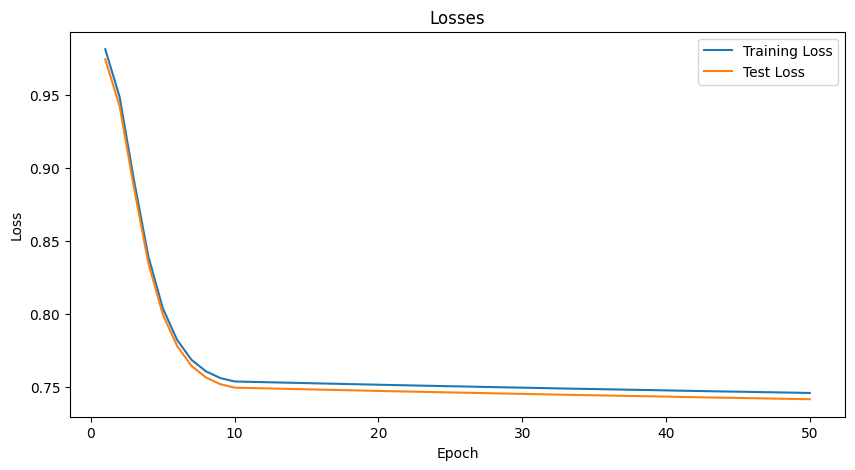

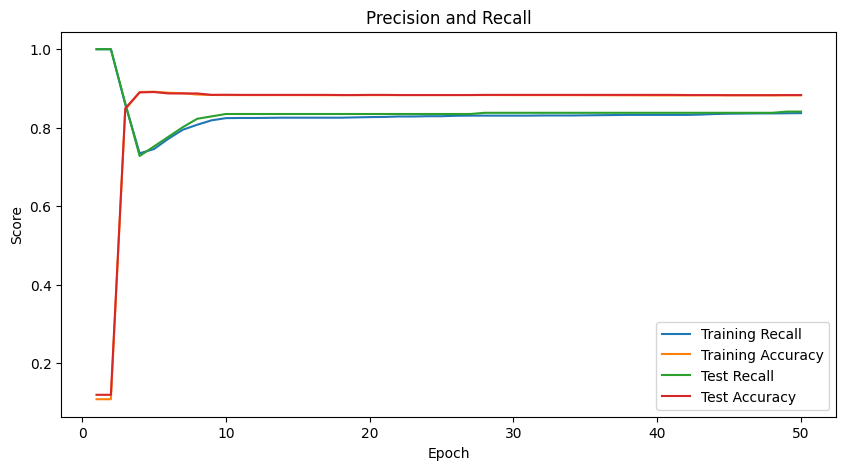

[[2153  269]
 [  52  275]]
best accuracy: 0.8908693790435791


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 10, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


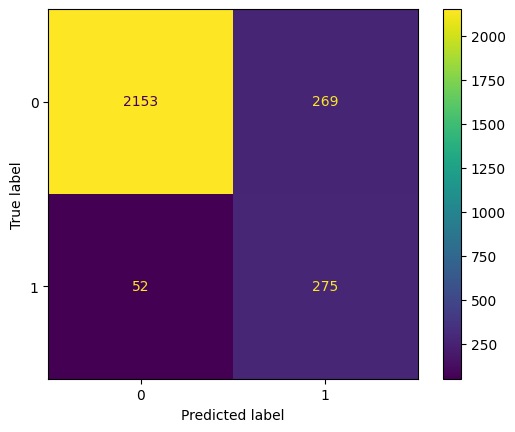

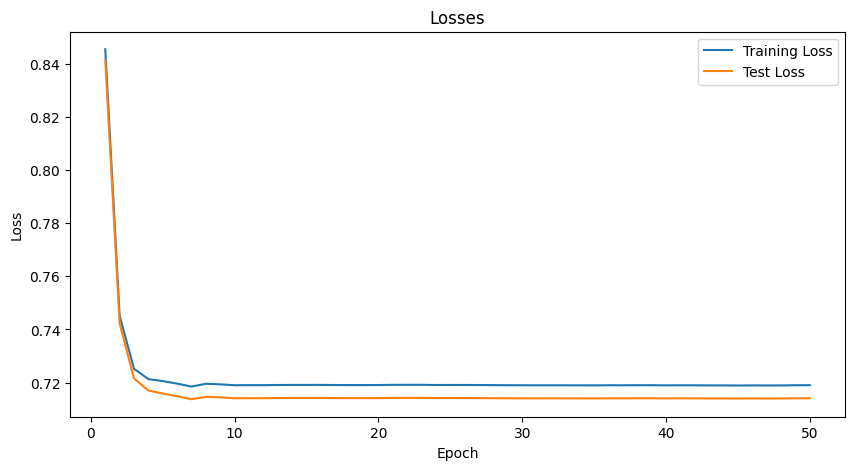

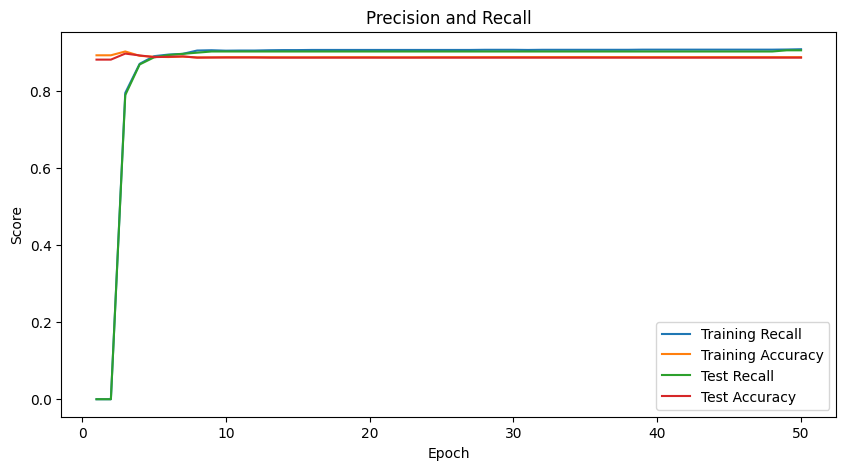

[[2140  282]
 [  31  296]]
best accuracy: 0.8966897130012512


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 20, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


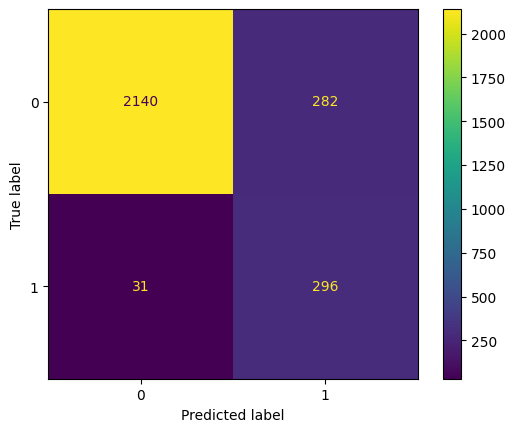

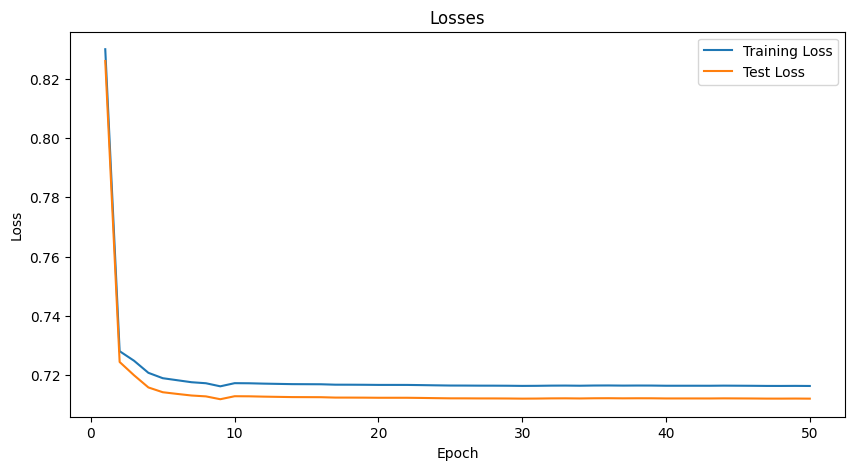

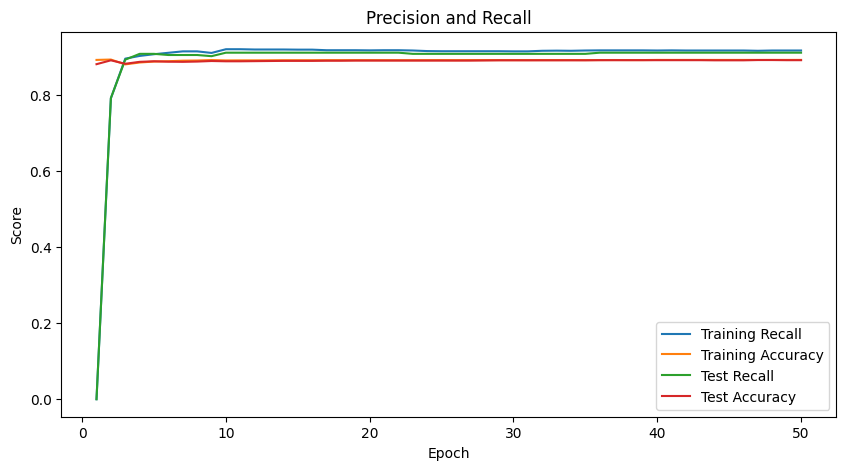

[[2153  269]
 [  29  298]]
best accuracy: 0.8919607400894165


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 40, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


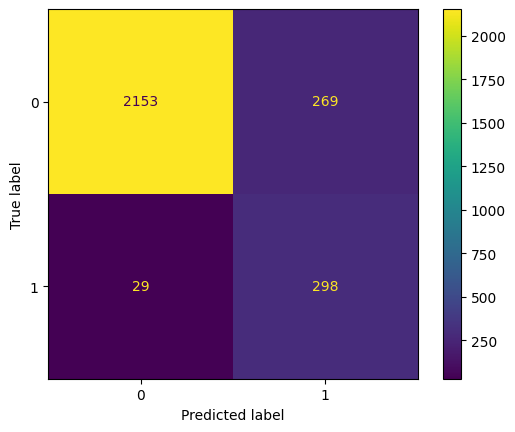

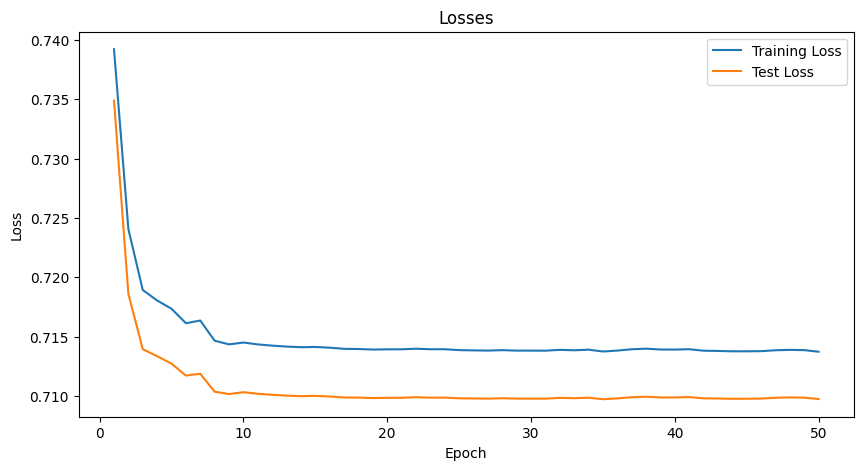

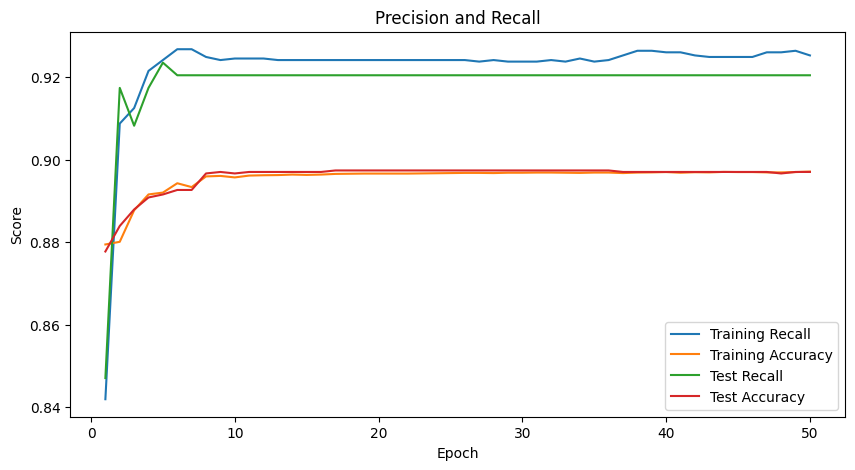

[[2165  257]
 [  26  301]]
best accuracy: 0.8974172472953796


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 80, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


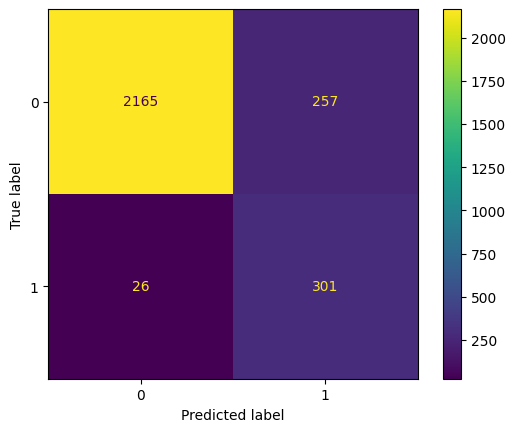

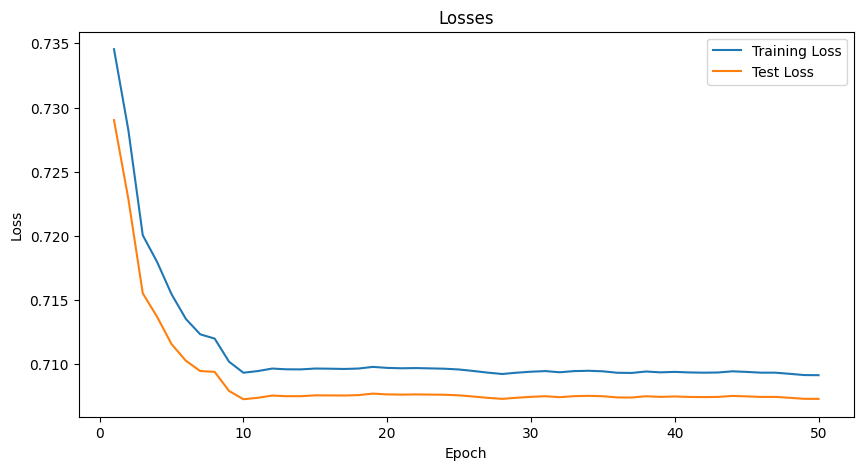

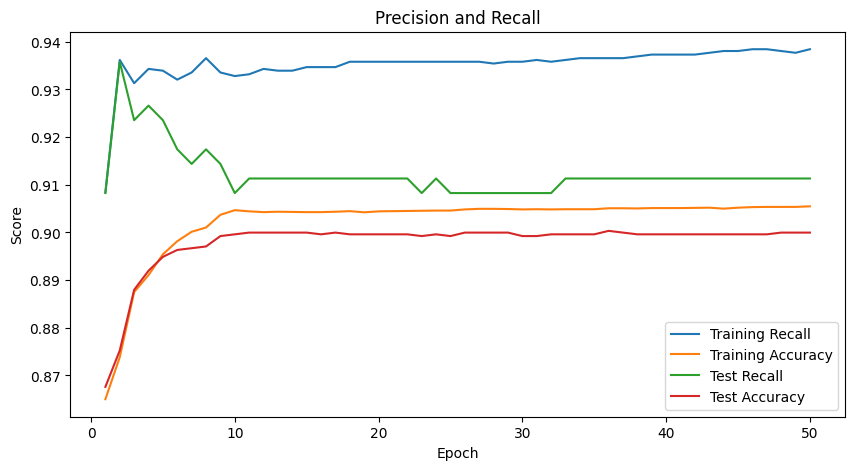

[[2176  246]
 [  29  298]]
best accuracy: 0.9003273844718933


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 140, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


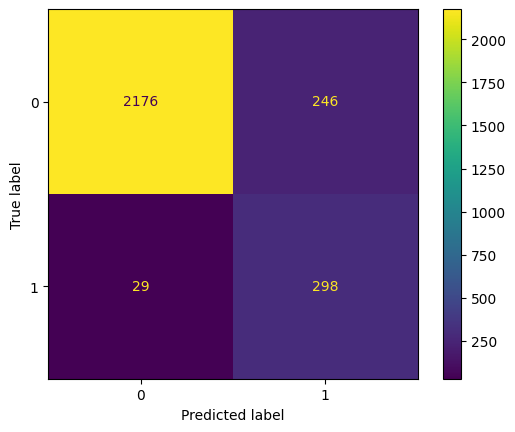

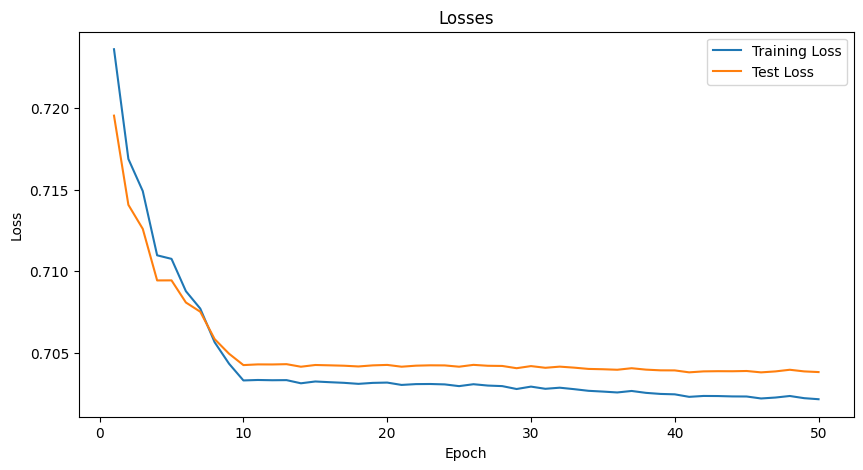

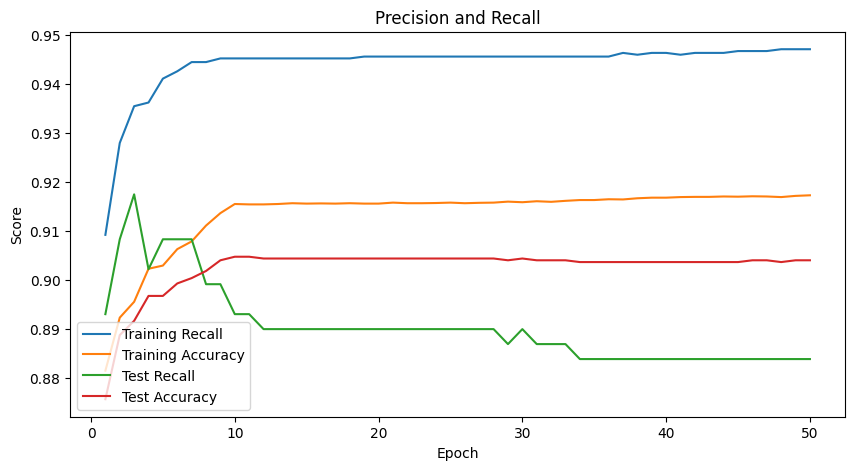

[[2196  226]
 [  38  289]]
best accuracy: 0.9046925902366638


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 180, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


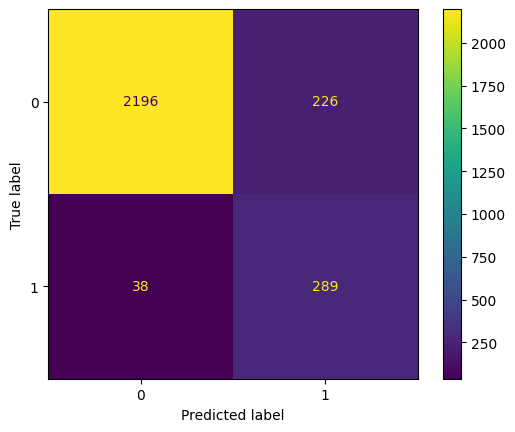

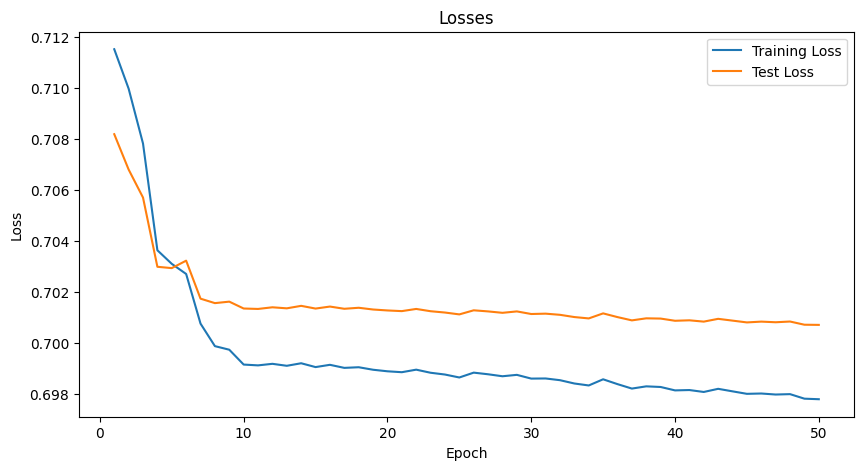

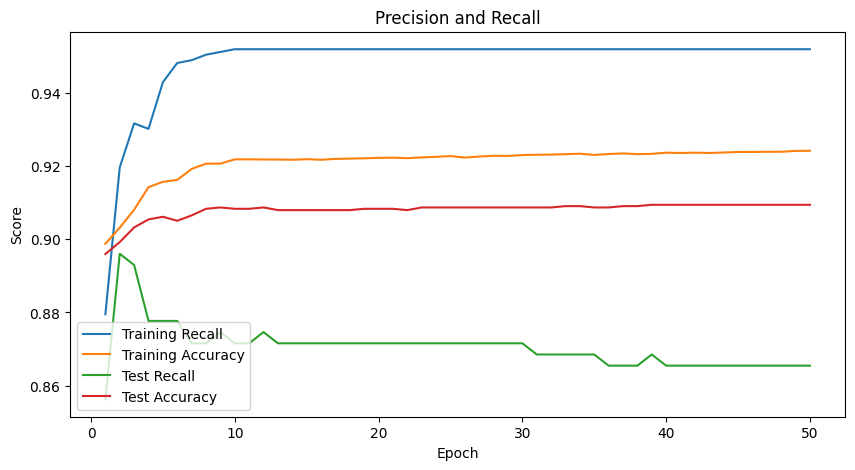

[[2217  205]
 [  44  283]]
best accuracy: 0.9094216227531433


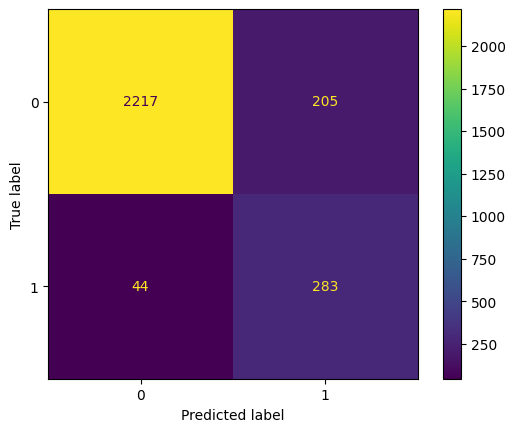

In [20]:
for hidden_size in [0.2,0.5,1,2,4,7,9]:
    model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = int(hidden_size * 20),
        n_hidden_layers_i = 2,
        learning_rate_i = 0.0001,
        n_epochs_i = 50,
        batch_size_i = 32,
        activation_f_i = nn.LeakyReLU)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 20, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


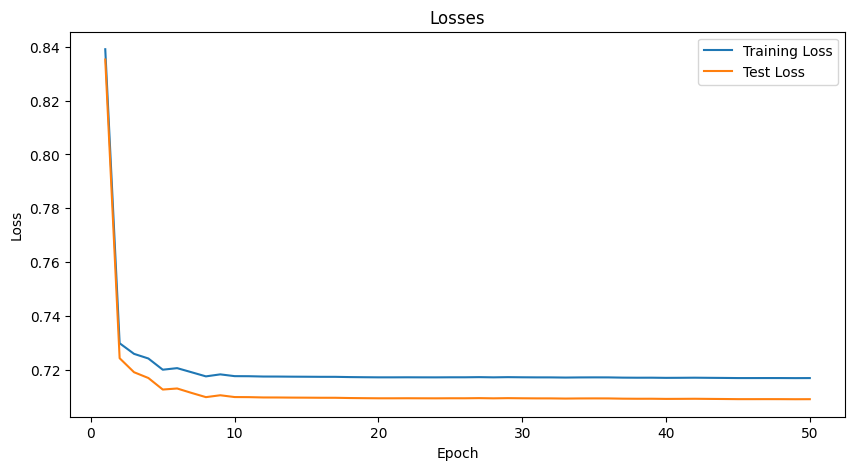

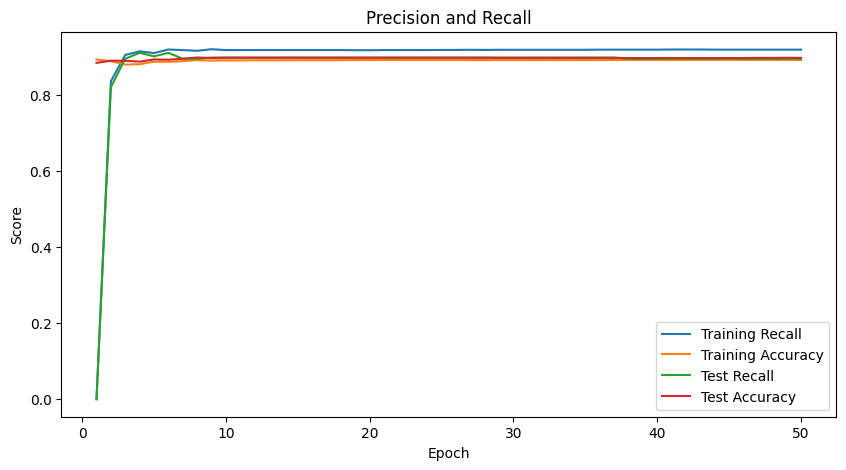

[[2177  251]
 [  34  287]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 180, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


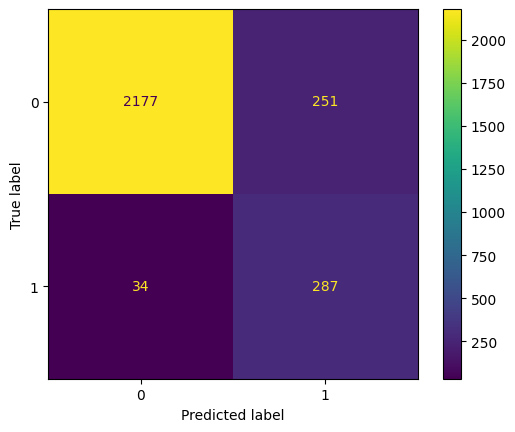

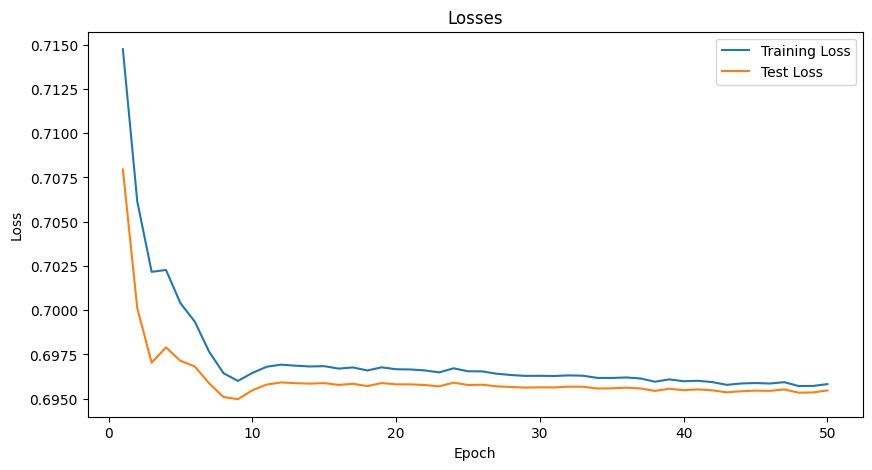

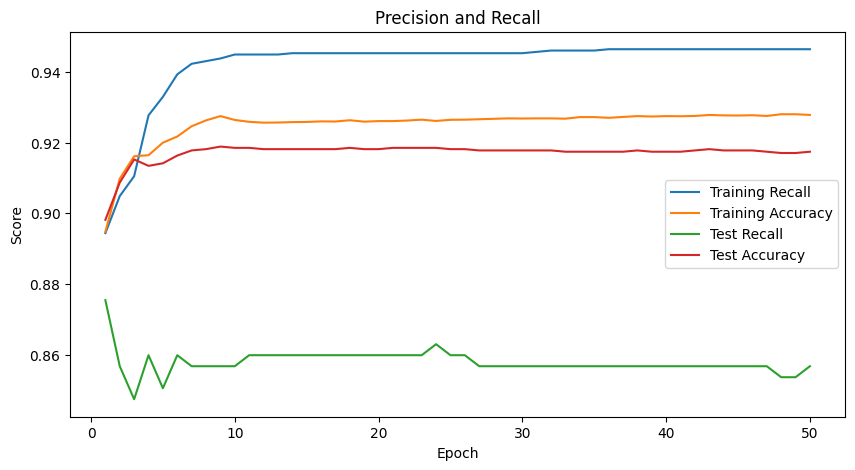

[[2247  181]
 [  46  275]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 360, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


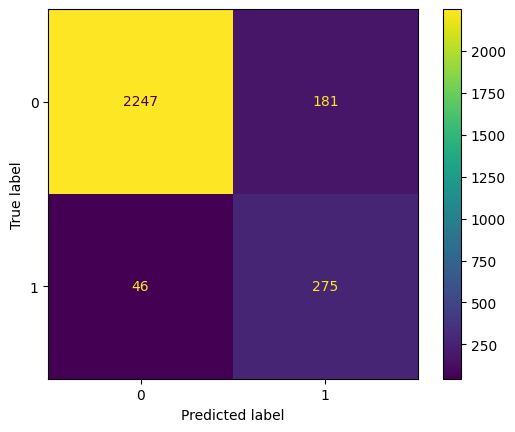

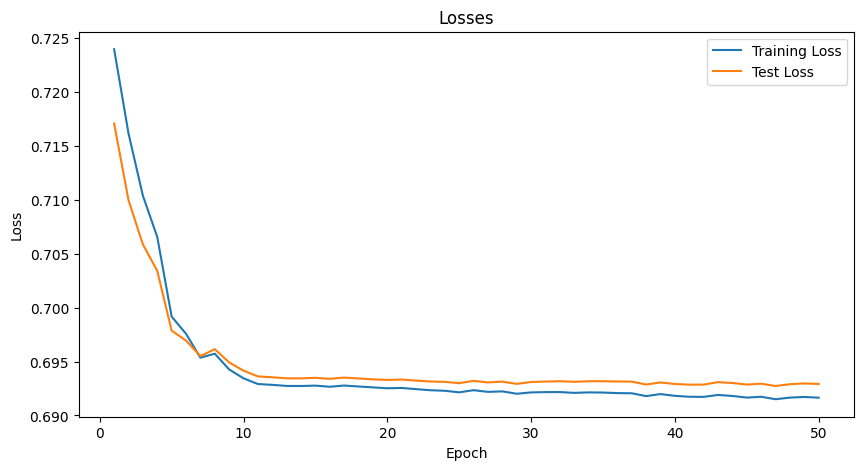

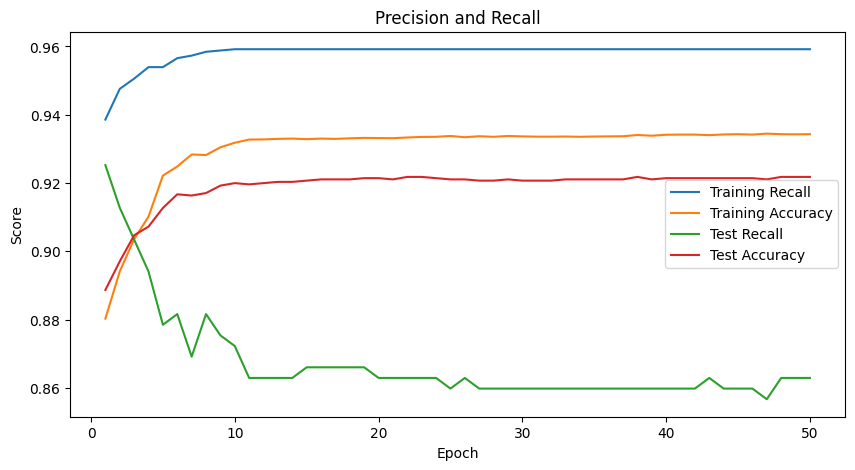

[[2257  171]
 [  44  277]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


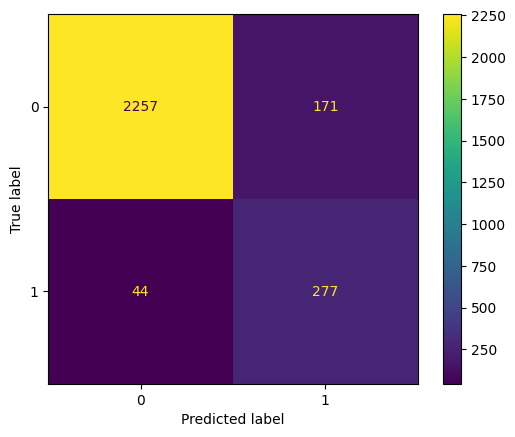

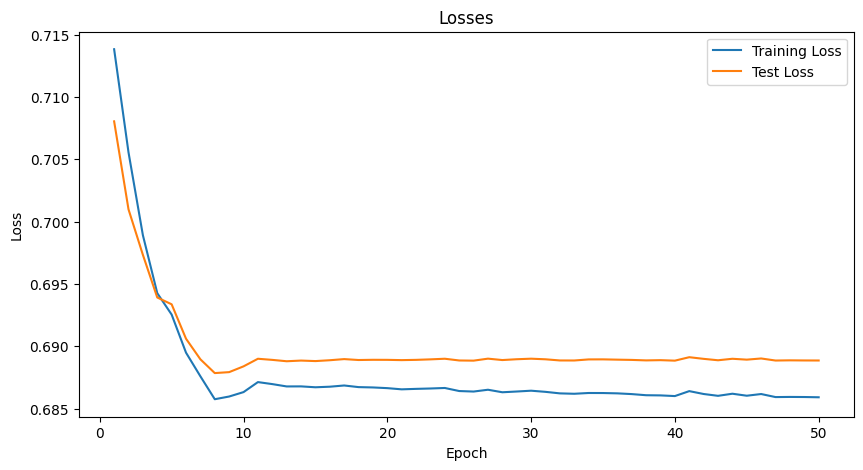

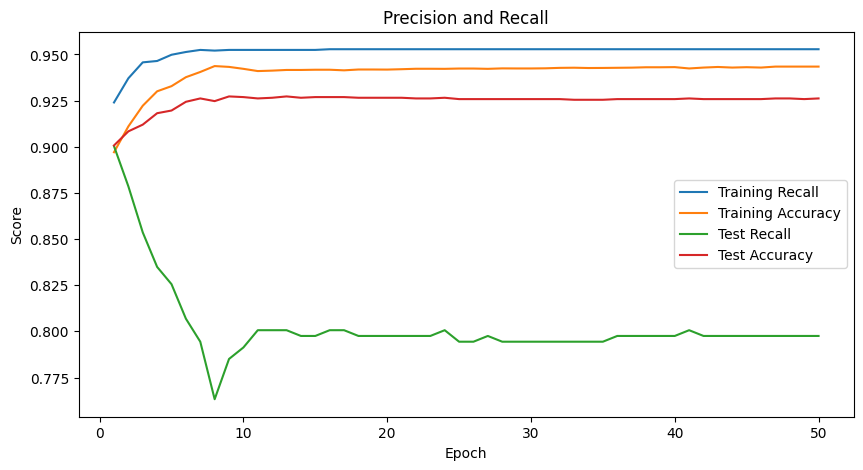

[[2290  138]
 [  65  256]]


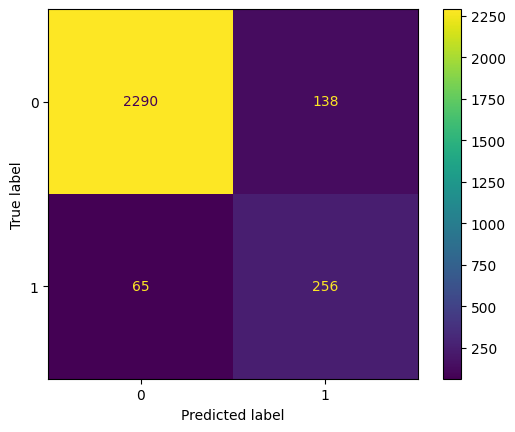

In [12]:
for hidden_size in [1,9,18, 27]:
    model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = hidden_size * 20,
        n_hidden_layers_i = 2,
        learning_rate_i = 0.0001,
        n_epochs_i = 50,
        batch_size_i = 32,
        activation_f_i = nn.LeakyReLU)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.1, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


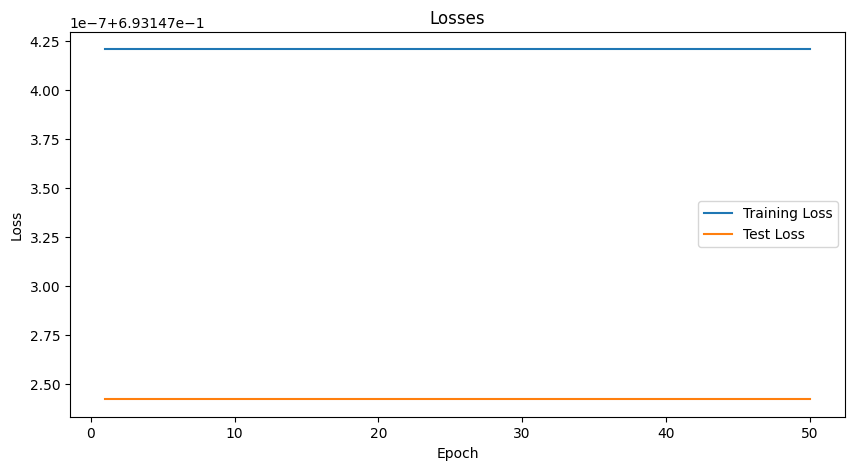

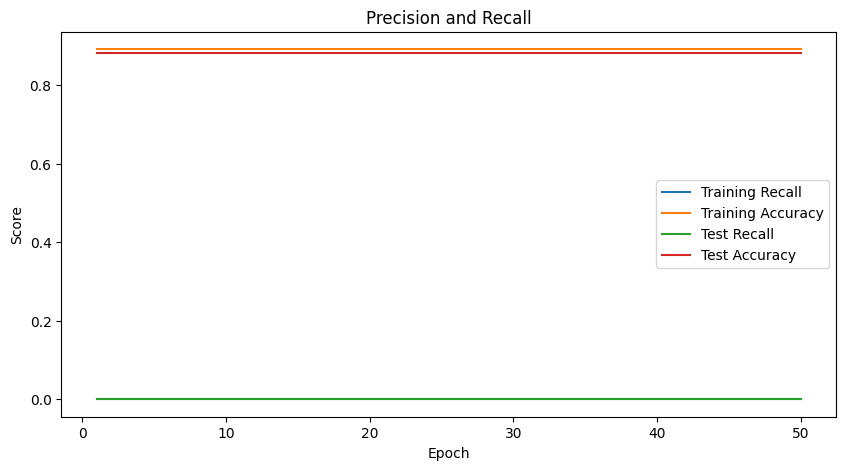

[[2428    0]
 [ 321    0]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.01, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


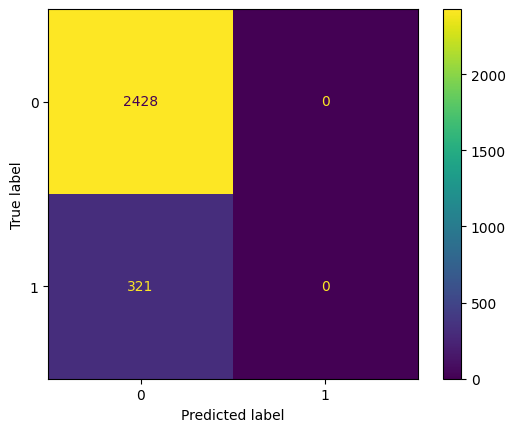

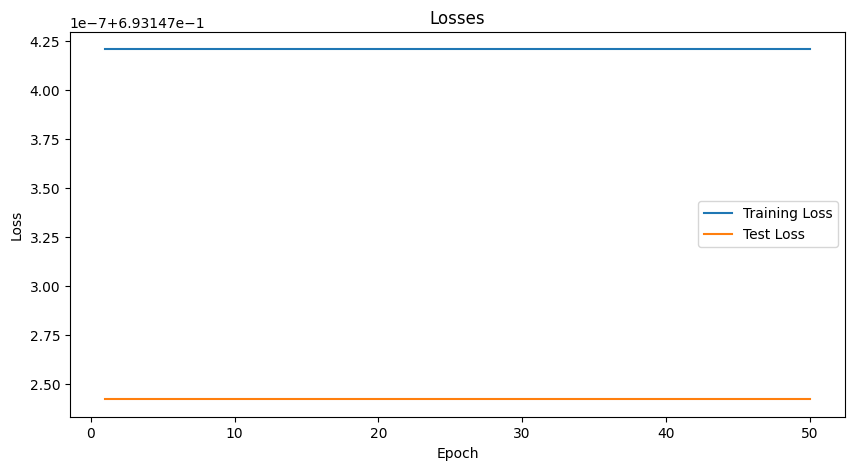

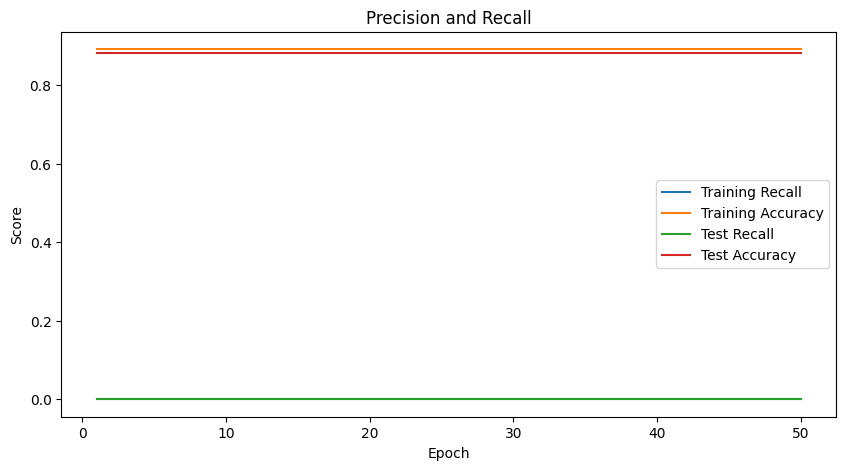

[[2428    0]
 [ 321    0]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


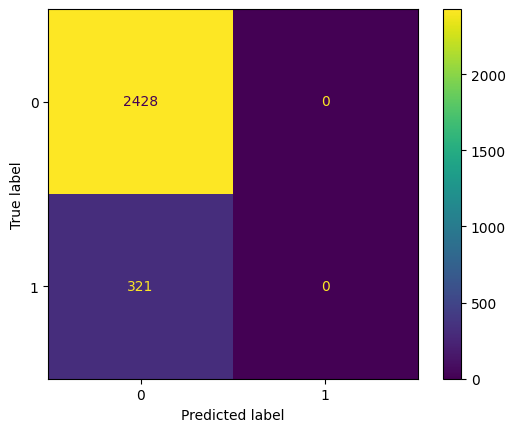

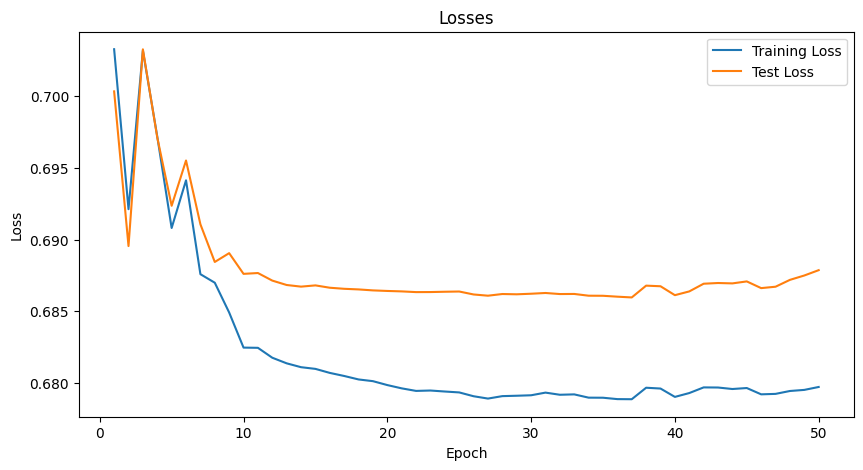

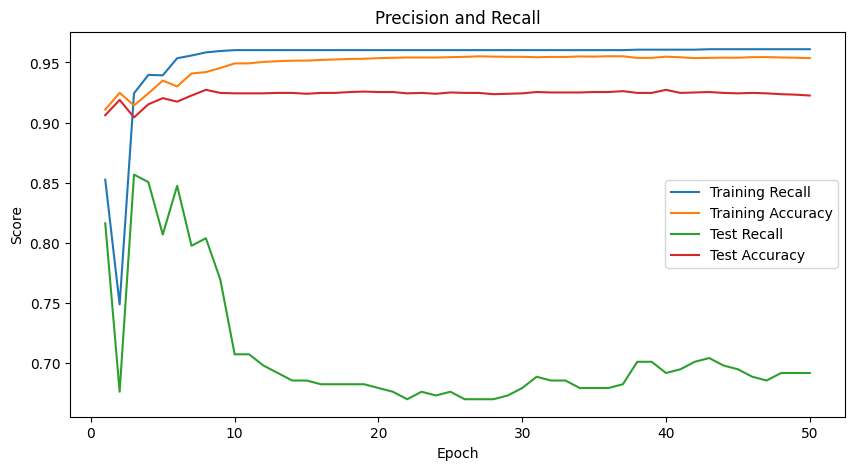

[[2314  114]
 [  99  222]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


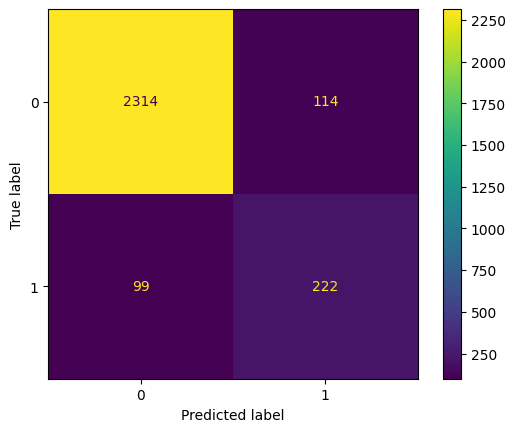

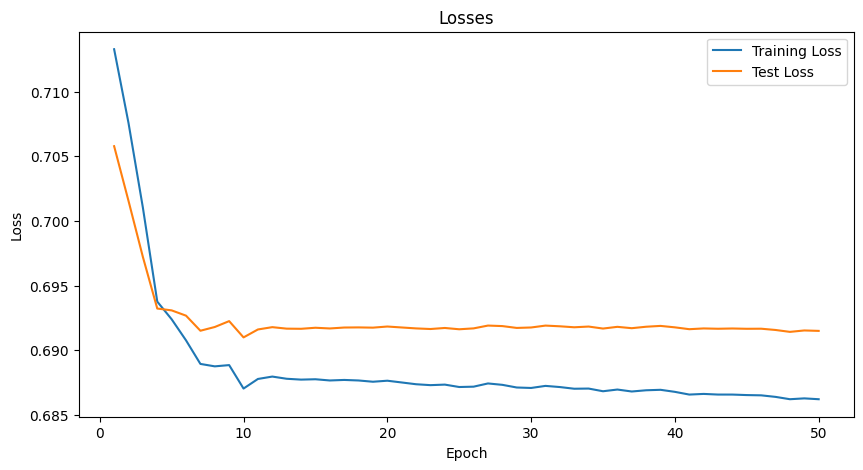

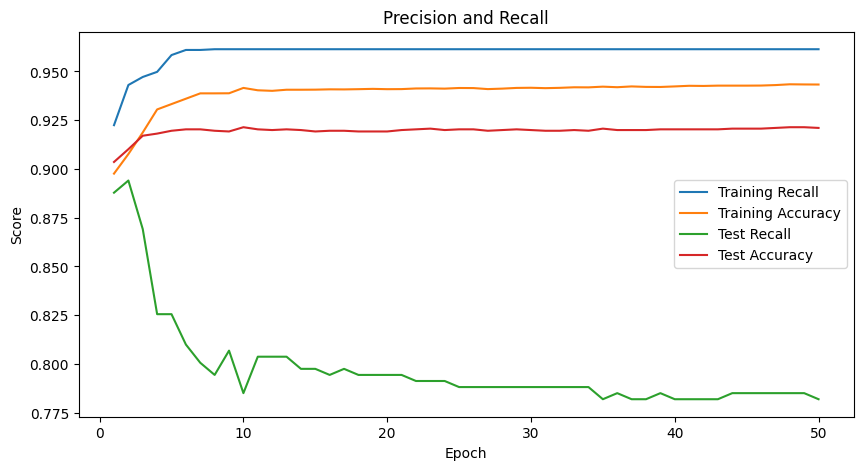

[[2281  147]
 [  70  251]]


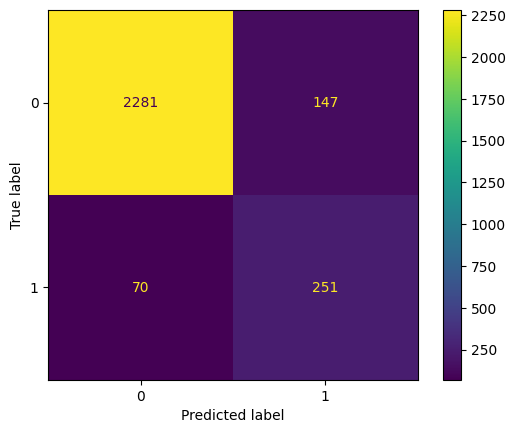

In [13]:
for lr in [0.1,0.01,0.001, 0.0001]:
    model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = 27 * 20,
        n_hidden_layers_i = 2,
        learning_rate_i = lr,
        n_epochs_i = 50,
        batch_size_i = 32,
        activation_f_i = nn.LeakyReLU)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 1, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


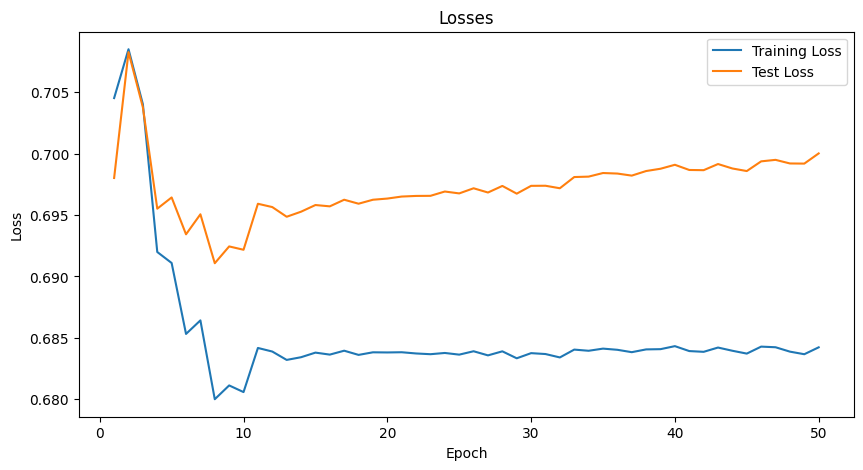

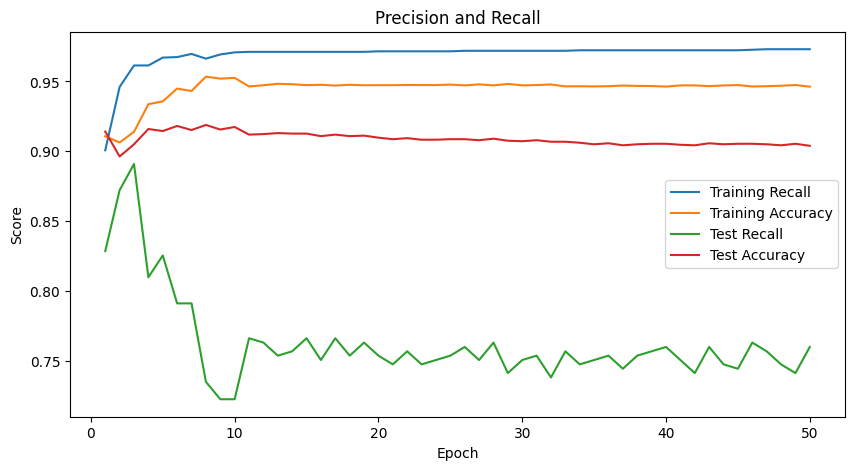

[[2241  187]
 [  77  244]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 16, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


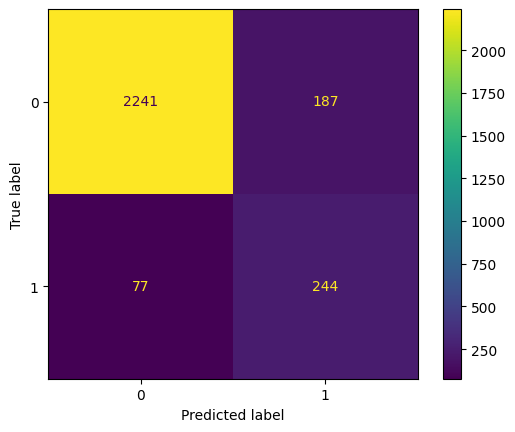

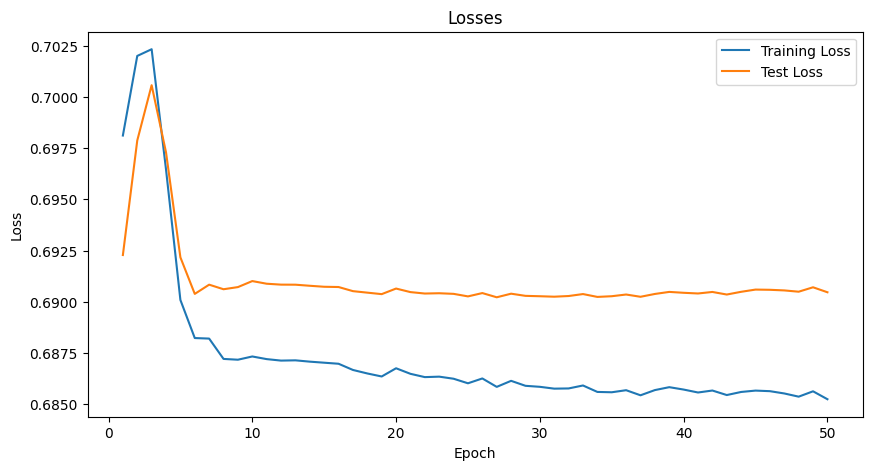

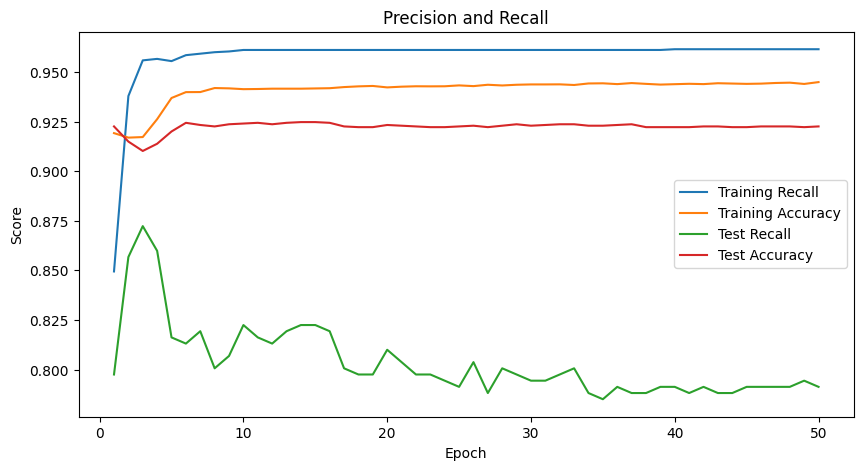

[[2282  146]
 [  67  254]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


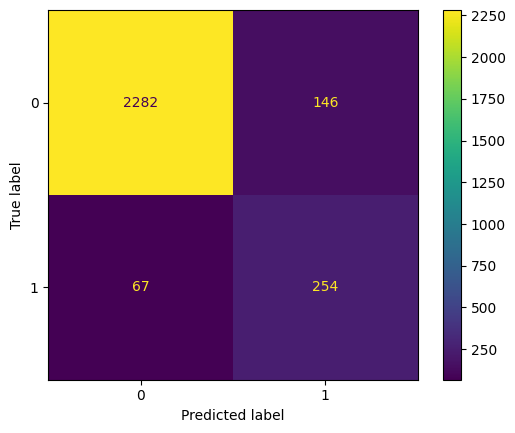

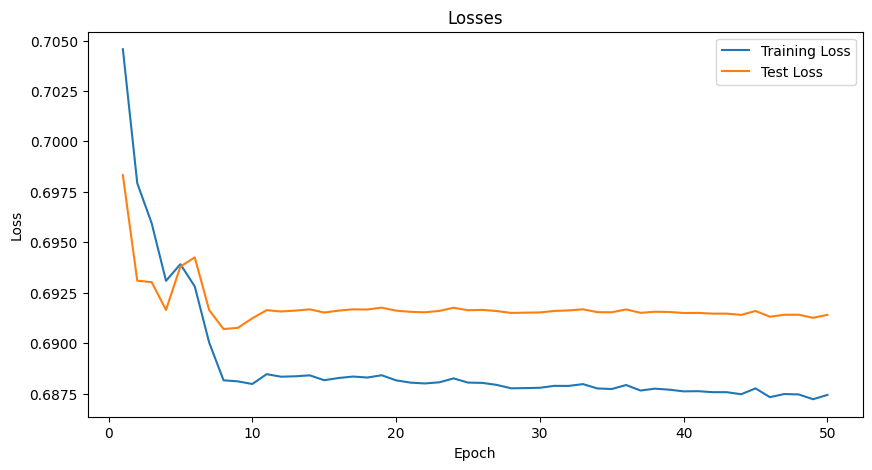

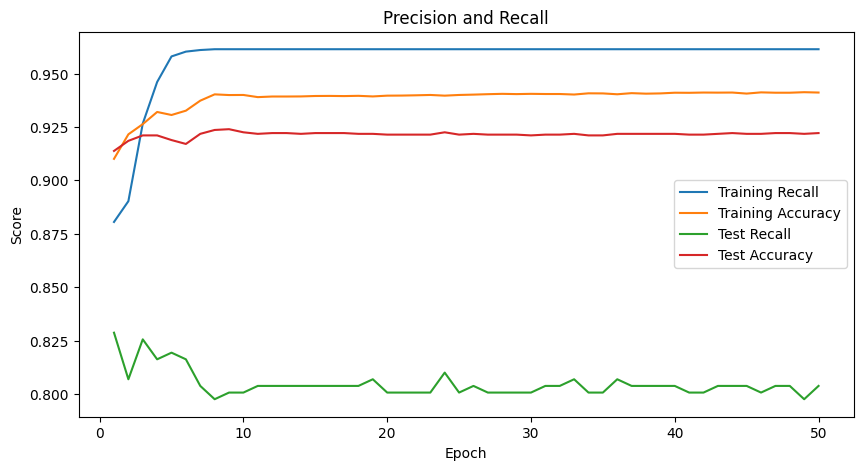

[[2277  151]
 [  63  258]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 256, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


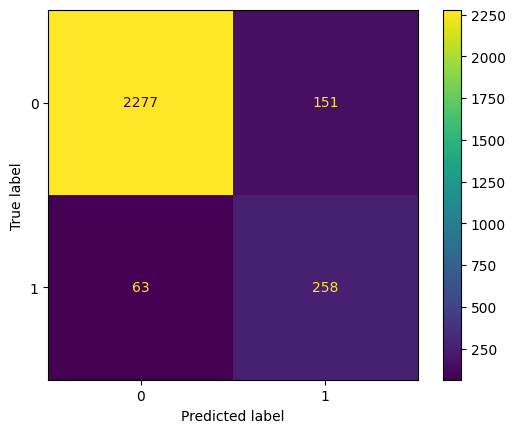

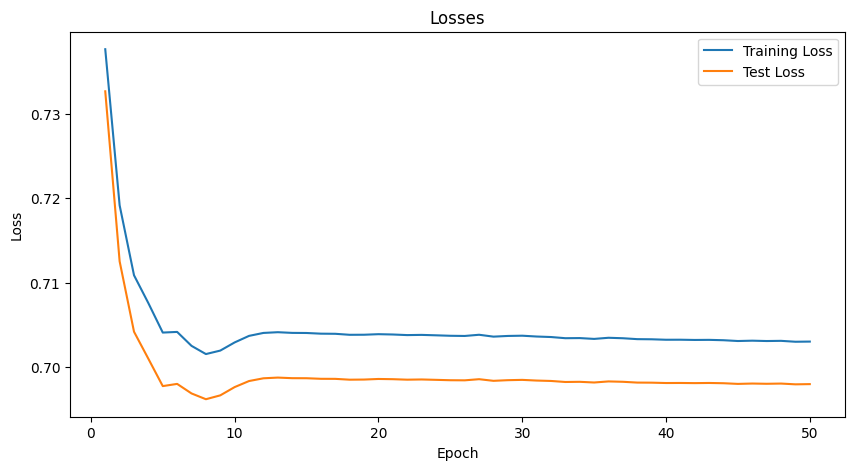

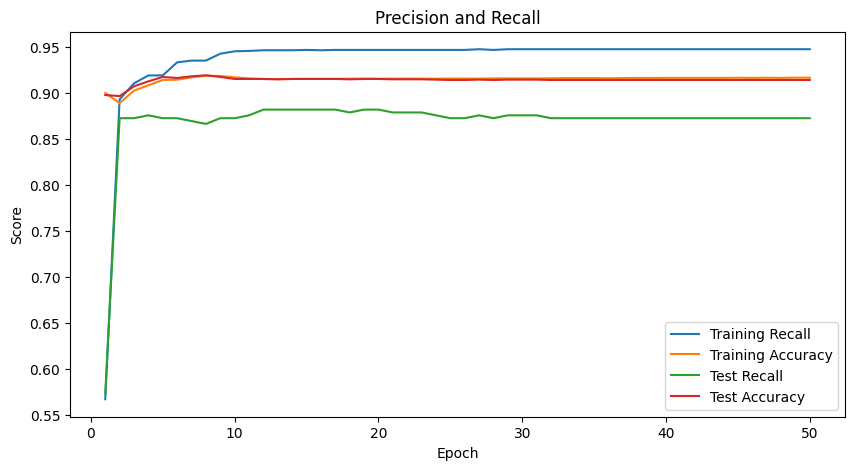

[[2232  196]
 [  41  280]]


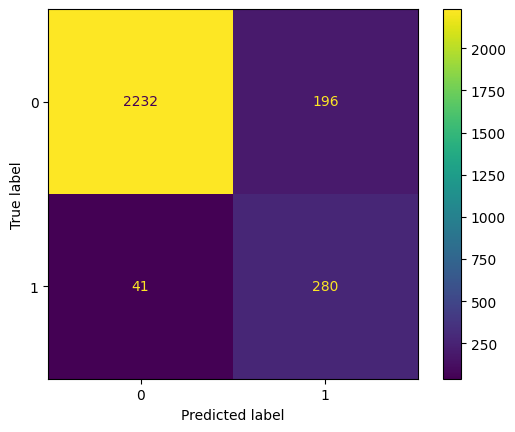

In [14]:
for batch_size in [1,16,32,256]:
    model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = 27 * 20,
        n_hidden_layers_i = 2,
        learning_rate_i = 0.0001,
        n_epochs_i = 50,
        batch_size_i = batch_size,
        activation_f_i = nn.LeakyReLU)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


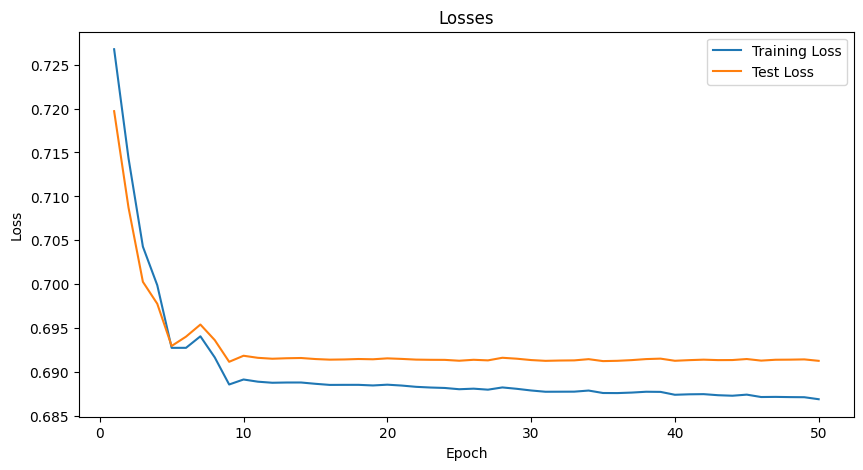

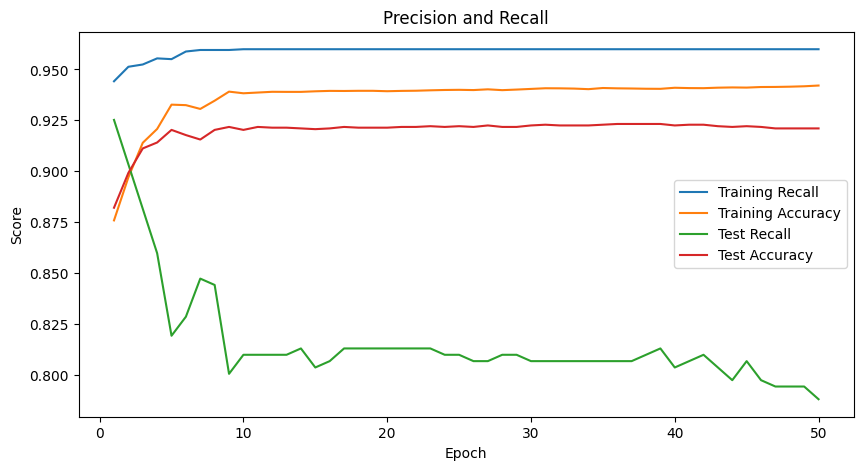

[[2279  149]
 [  68  253]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.ReLU'>


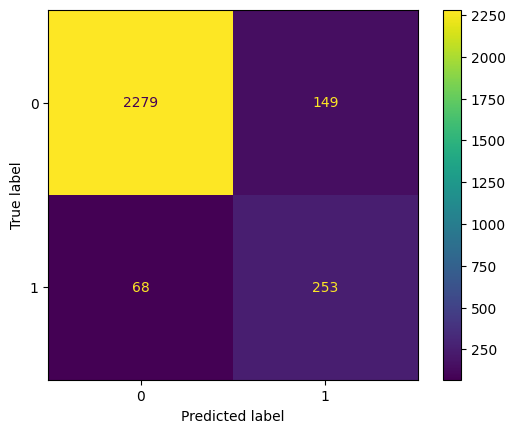

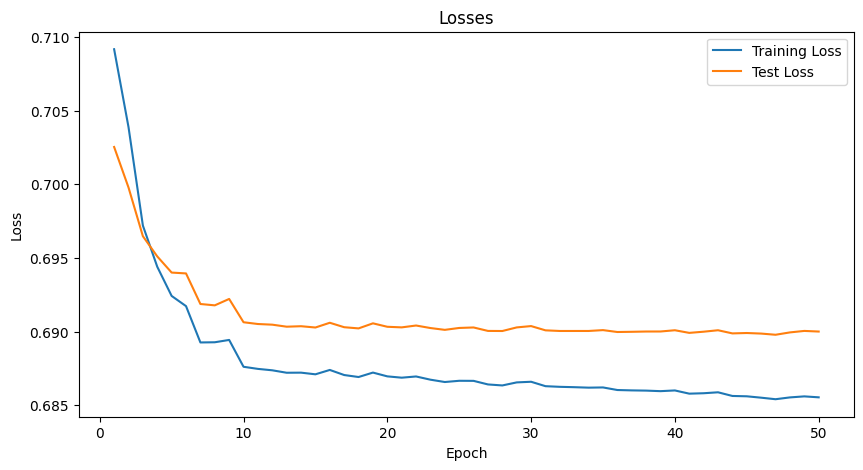

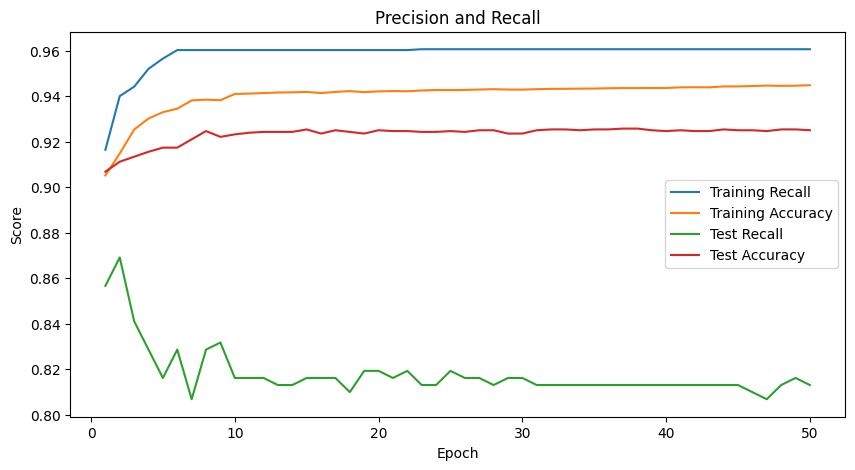

[[2282  146]
 [  60  261]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.GELU'>


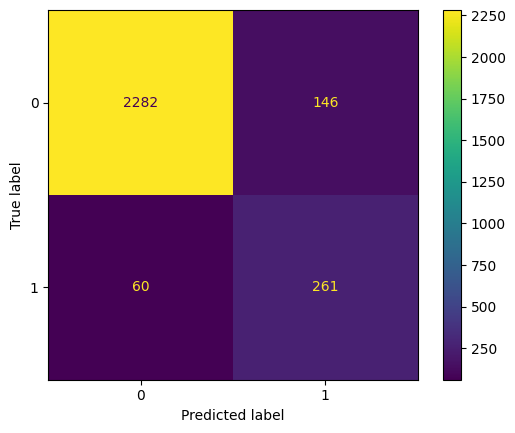

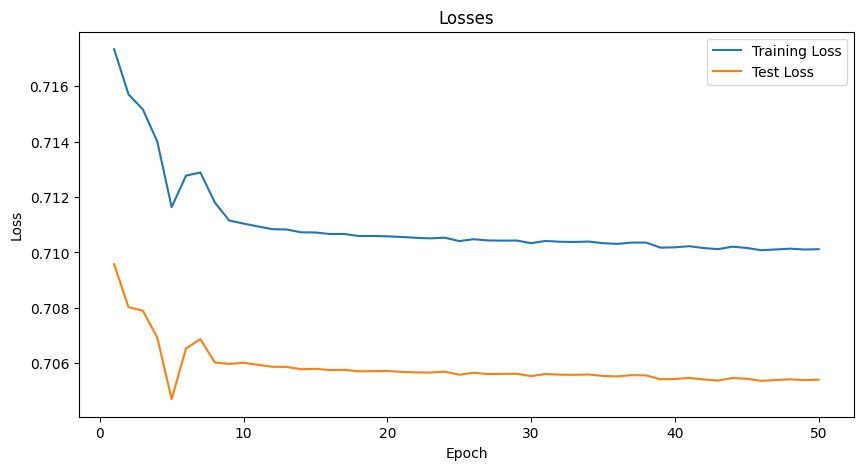

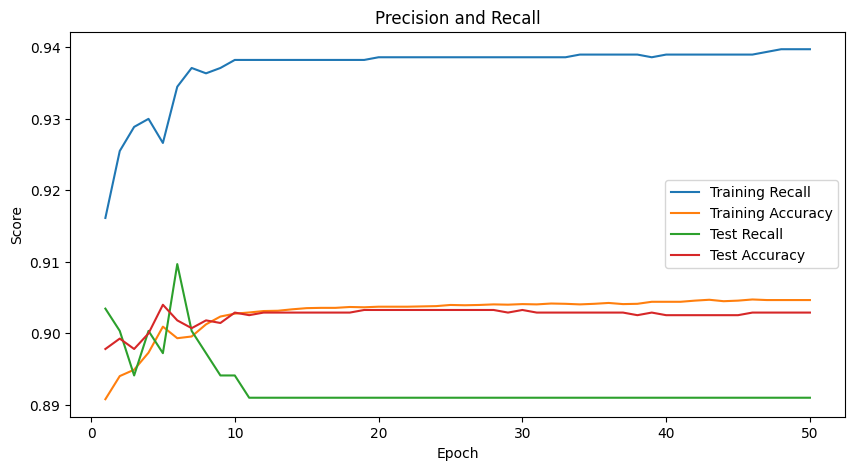

[[2196  232]
 [  35  286]]


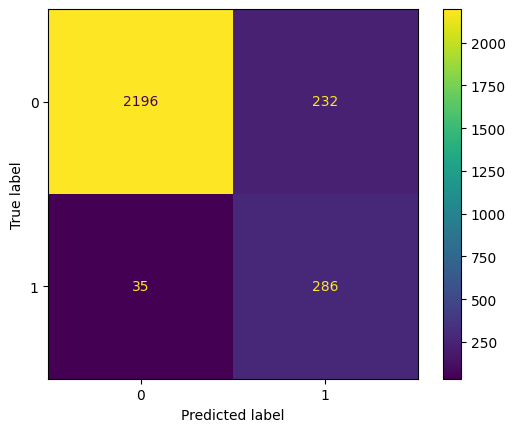

In [15]:
for activation in [nn.LeakyReLU, nn.ReLU, nn.GELU]:
    model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = 27 * 20,
        n_hidden_layers_i = 2,
        learning_rate_i = 0.0001,
        n_epochs_i = 50,
        batch_size_i = 32,
        activation_f_i = activation)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 0, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.GELU'>


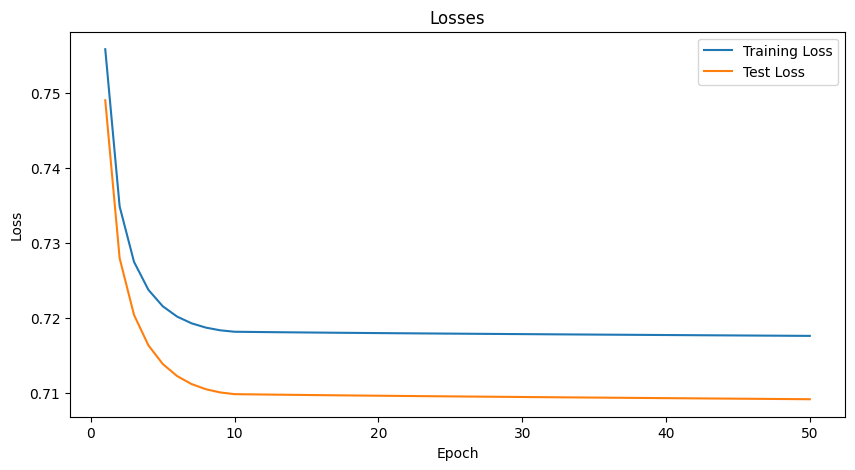

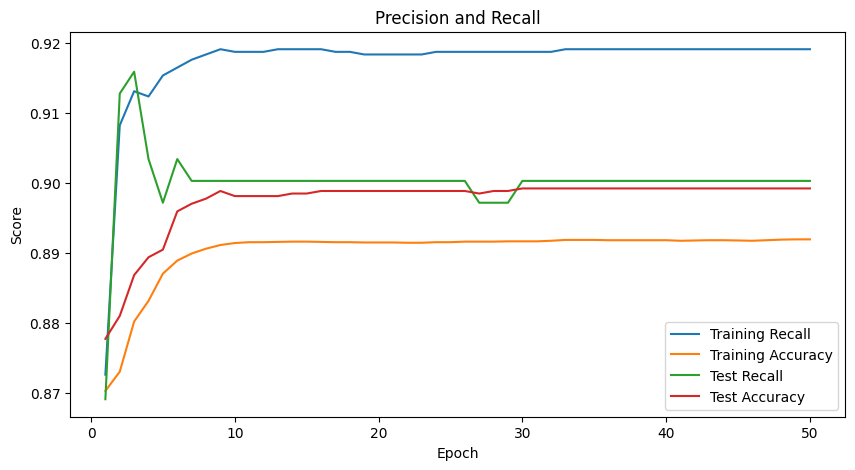

[[2183  245]
 [  32  289]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.GELU'>


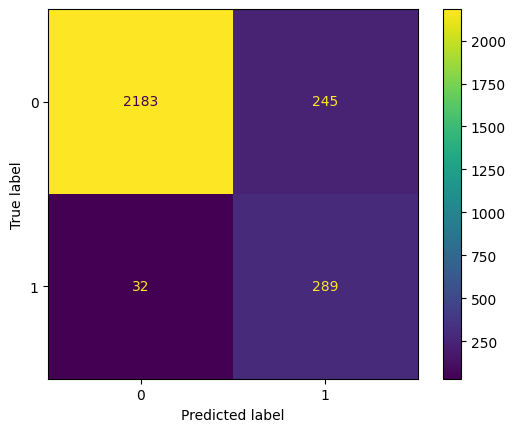

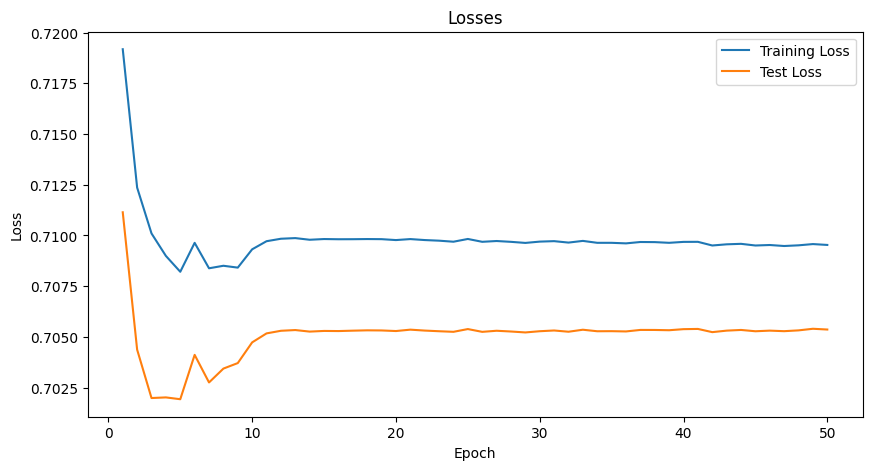

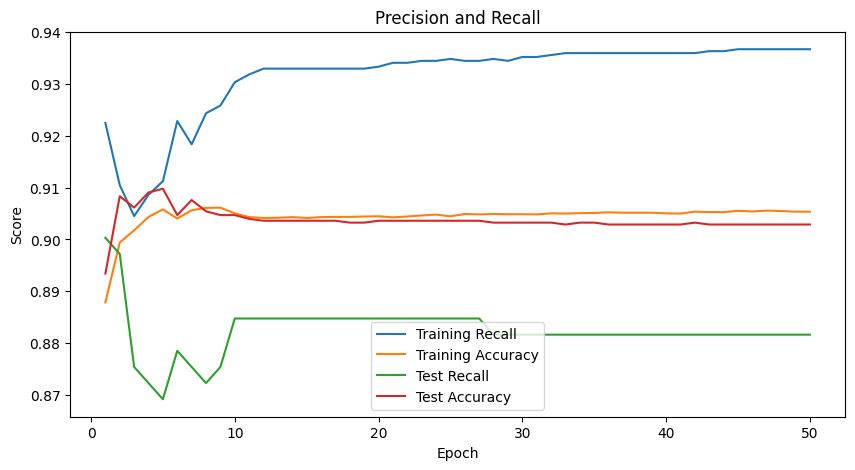

[[2199  229]
 [  38  283]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 5, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.GELU'>


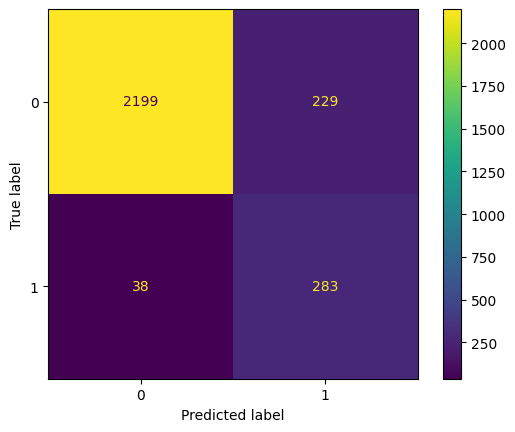

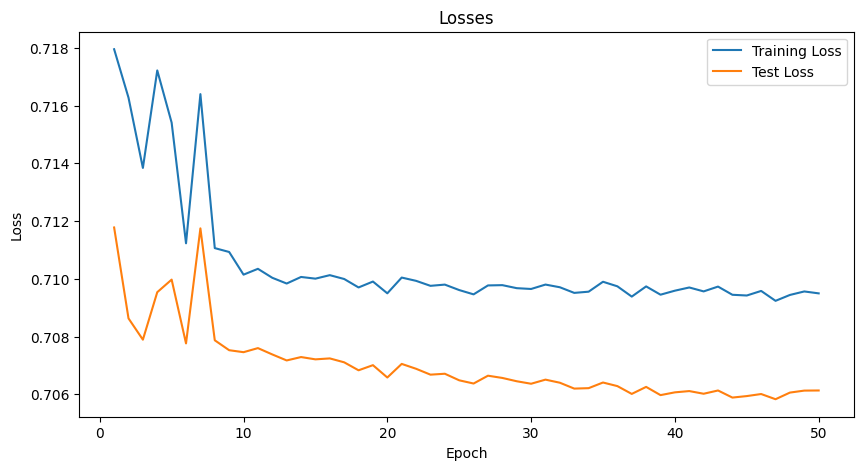

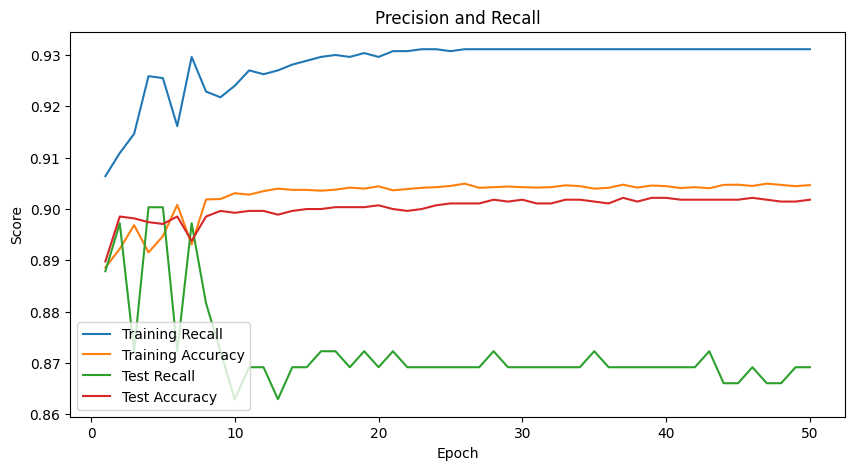

[[2200  228]
 [  42  279]]


/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 8, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.GELU'>


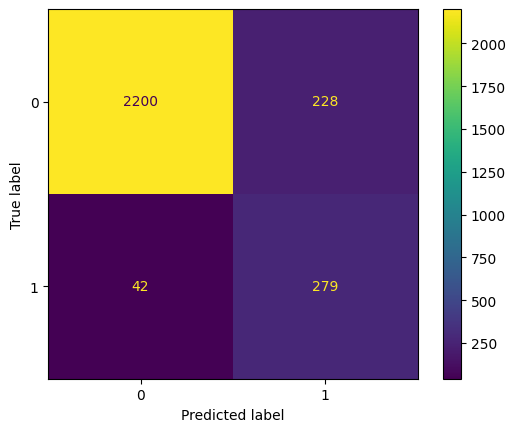

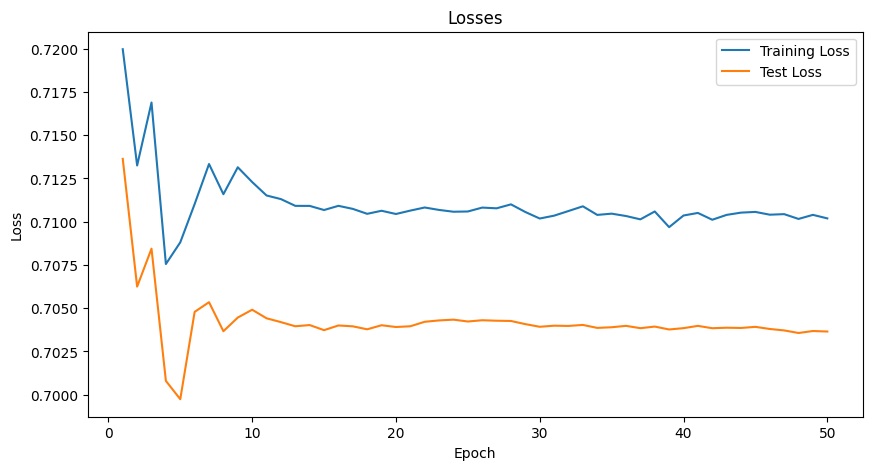

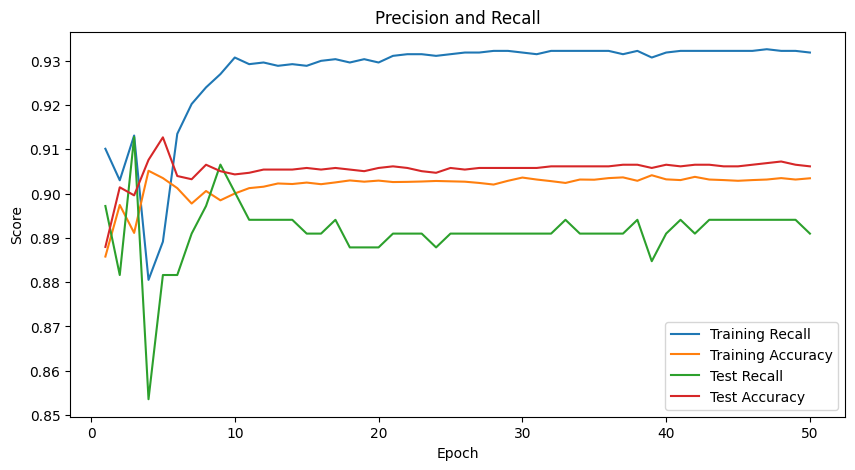

[[2205  223]
 [  35  286]]


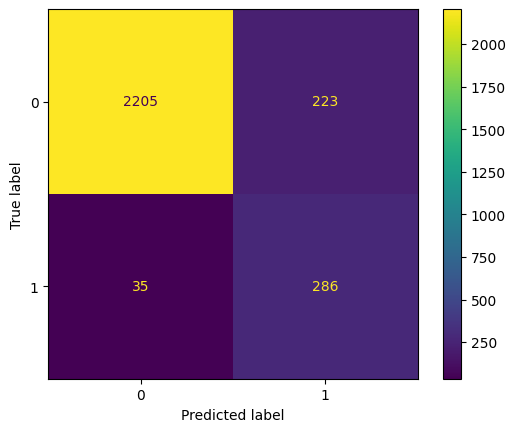

In [16]:
for n_hidden_layers in [0,2,5,8]:
    model = run_experiment(input_size_i = 9 * 20,
        hidden_size_i = 27 * 20,
        n_hidden_layers_i = n_hidden_layers,
        learning_rate_i = 0.0001,
        n_epochs_i = 50,
        batch_size_i = 32,
        activation_f_i = activation)

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


hidden_size: 540, n_hidden_layers: 2, LR: 0.0001, batch_size: 32, activation: <class 'torch.nn.modules.activation.LeakyReLU'>


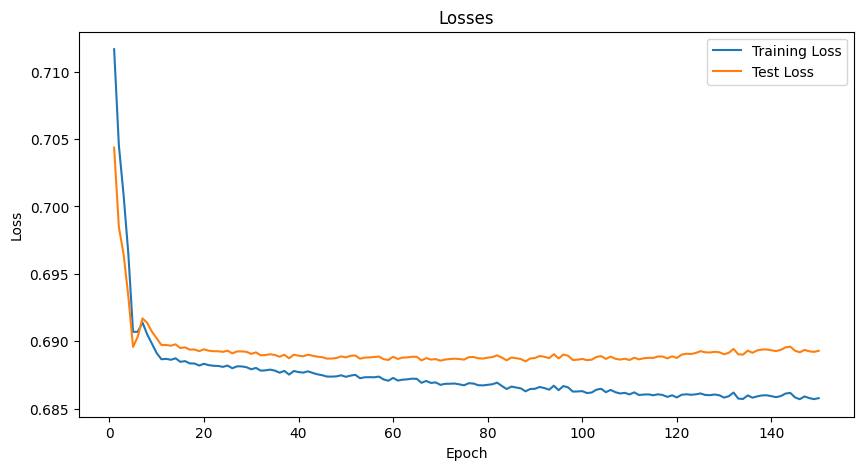

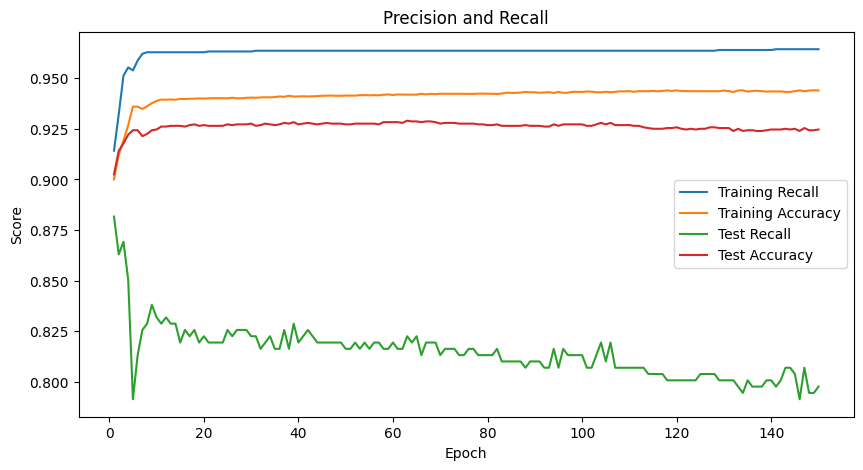

[[2286  142]
 [  65  256]]


0.9290651145871226

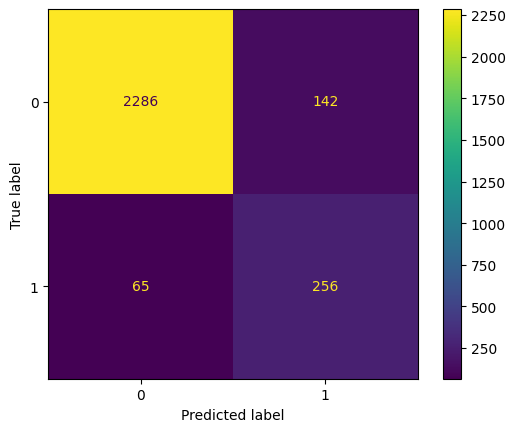

In [59]:
from sklearn.metrics import accuracy_score

model = run_experiment(9 * 20,
        hidden_size_i = 27 * 20,
        n_hidden_layers_i = 2,
        learning_rate_i = 0.0001,
        n_epochs_i = 150,
        batch_size_i = 32,
        activation_f_i = nn.LeakyReLU, train_base_ds=train_before_alter, under_sampling_ratio=2,over_sampling_ratio=4)

test_outputs = model(test_data.to(device)).cpu()
test_predictions = (test_outputs >= 0.5).float()

accuracy_score(test_labels, test_predictions)

In [58]:
sars_cov_2_acids = open('./data/sars_acids', 'r').read()

all_sars_9_mer = [sars_cov_2_acids[n:n+9] for n in range(len(sars_cov_2_acids)-8)]

def get_pred(txt_input):
    sample_input = torch.Tensor([char_to_label[c] for c in list(txt_input)]).to(device)
    sample_input = torch.flatten(F.one_hot(sample_input.to(torch.int64), num_classes=20)).to(torch.float)
    predicted_output = model(sample_input)
    return torch.sigmoid(predicted_output).item()

all_sars_with_pred = [(a, get_pred(a), get_pred(a) > 0.5) for a in all_sars_9_mer]
sorted(all_sars_with_pred, key=lambda x: x[1], reverse=True)[:3]

[('LLFNKVTLA', 0.7310583591461182, True),
 ('FIAGLIAIV', 0.7310575842857361, True),
 ('LLALHRSYL', 0.7310528755187988, True)]